<a href="https://colab.research.google.com/github/dtabuena/Images/blob/main/Nell2/Nell2_image_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install python-bioformats


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 40.3 MB 1.9 MB/s 
     |████████████████████████████████| 829 kB 43.0 MB/s 
     |████████████████████████████████| 132 kB 40.7 MB/s 
     |████████████████████████████████| 1.3 MB 45.1 MB/s 
     |████████████████████████████████| 9.3 MB 33.5 MB/s 
     |████████████████████████████████| 79 kB 7.8 MB/s 
     |████████████████████████████████| 140 kB 40.8 MB/s 
  Created wheel for python-javabridge: filename=python_javabridge-4.0.3-cp37-cp37m-linux_x86_64.whl size=1628131 sha256=a831257edff0bac3718d72b7ad9382b1b2545698608ff71b199a23649ab61597
  Stored in directory: /root/.cache/pip/wheels/63/7e/91/01b1bd8d29b4323834feb5cfec49b857fb212e6efc74ce103c
  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491070 sha256=f6da9d81c10266eb9d3d54c22813e7f7ac683fbe55624cc94968cd99ab57b4d2
  Stored in directory: /root/.cache/pip/wheels/56/b0/

In [17]:
import numpy as np
import pandas as pd
import javabridge
import bioformats
import skimage
from skimage import filters
from matplotlib import pyplot as plt
import matplotlib
import os
import scipy
from scipy import ndimage as ndi
javabridge.start_vm(class_path=bioformats.JARS)



def get_drobox_folder(link, new_filename):
    'Download a folder from dropbox and unzip'
    zipped_file_path = "/content/"+new_filename + ".zip"
    unzipped_file_path = "/content/"+new_filename
    if not( os.path.exists(zipped_file_path)):
        !wget -O $zipped_file_path $link    # download with new name
    !echo A | unzip $zipped_file_path -d $unzipped_file_path 
    return new_filename

def get_sub_files(rootdir):
    'Recursively search subfolders and return a list of all files'
    file_list =[]
    for rootdir, dirs, files in os.walk(rootdir): 
            file_list.extend([os.path.join(rootdir,f) for f in files])
    return file_list


data_drop_folder = 'https://www.dropbox.com/sh/dbuo3g9pd598xmw/AABx6mF-MN7Pyhr4xZWmOfWka?dl=0' # NELL2

folder = get_drobox_folder(data_drop_folder, 'images')
file_list = get_sub_files(folder)
file_list.sort()
file_list = [f for f in file_list if 'DAPI' not in f]

Archive:  /content/images.zip
mapname:  conversion of  failed
replace /content/images/Nell2_08-04-22_DG_40X_2XZoom_1.oir? [y]es, [n]o, [A]ll, [N]one, [r]ename:  extracting: /content/images/Nell2_08-04-22_DG_40X_2XZoom_1.oir  
 extracting: /content/images/Nell2_08-09-22_DG_40X_2XZoom_1.oir  
 extracting: /content/images/Nell2_08-10-22_DG_40X_2XZoom_1.oir  
 extracting: /content/images/Nell2_08-04-22_CA3_40X_2XZoom_1.oir  
 extracting: /content/images/Nell2_08-09-22_CA3_40X_2XZoom_1.oir  
 extracting: /content/images/Nell2_08-10-22_CA3_40X_2XZoom_1.oir  
 extracting: /content/images/Nell2_08-04-22_S001_DG_40X_2XZoom_1.oir  
 extracting: /content/images/Nell2_08-04-22_S002_DG_40X_2XZoom_1.oir  
 extracting: /content/images/Nell2_08-10-22__S001_DG_40X_2XZoom_2.oir  
 extracting: /content/images/Nell2_08-04-22_S001_CA3_40X_2XZoom_1.oir  
 extracting: /content/images/Nell2_08-04-22_S002_CA3_40X_2XZoom_1.oir  
 extracting: /content/images/Nell2_08-10-22__S001_CA3_40X_2XZoom_2.oir  
 extractin

In [ ]:
import os
os.environ["CELLPOSE_LOCAL_MODELS_PATH"] = "/PATH_FOR_MODELS/"

!pip install cellpose
from cellpose import models

In [15]:
def read_image(image_name):
    my_reader = bioformats.get_image_reader('my_image', image_name)

    c_dim = my_reader.rdr.getSizeC()
    z_dim = my_reader.rdr.getSizeZ()
    x_dim = my_reader.rdr.getSizeX()
    y_dim = my_reader.rdr.getSizeY()
    # print(x_dim,y_dim,c_dim,z_dim)

    image = np.empty([x_dim,y_dim,c_dim,z_dim])
    for zi in range(z_dim):
        img_zi = my_reader.read(c=None, z=zi,rescale=True)
        image[:,:,:,zi] = img_zi

    for ci in range(image.shape[2]):
        cim = image[:,:,ci,:]
        flat = cim.flatten()
        max= np.percentile(flat,100)
        assert max>0 , print(flat)
        cim = cim/max
        image[:,:,ci,:] = cim
    return image


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
# def score_image(image,chan_dim,cell_chan):
chan_dim = 2
cell_chan = 2
z_dim = 3
diameter = 30
min_vox = 500
ch_names = ['target','mCherry','NeuN']


def norm_channels(image,chan_dim,z_dim,):
    '''Transpose ndims, preserve labels'''
    dim_order = np.arange(image.ndim).tolist()
    dim_order = [chan_dim, z_dim] + [d for d in dim_order if d not in [chan_dim, z_dim]]
    chan_dim = [i for i in range(len(dim_order)) if dim_order[i]==chan_dim][0]
    z_dim = [i for i in range(len(dim_order)) if dim_order[i]==z_dim][0]

    '''Normalize channel intensities'''
    image_r=np.transpose(image.copy(),dim_order)
    ch_val_list = []
    for ch in range(image_r.shape[chan_dim]):    
        ch_val = image_r[ch,:,:,:].copy()
        for zi in range(image_r.shape[z_dim]):
            ch_val_z = ch_val[zi,:,:]
            ch_val_z = (ch_val_z-np.mean(ch_val_z.flatten())) / np.std(ch_val_z.flatten()) # zscore
            ch_val_z = (ch_val_z) / np.std(ch_val_z.flatten())
            ch_val[zi,:,:] = ch_val_z
        ch_val_list.append(ch_val)
    image_znorm = np.stack(ch_val_list,axis=0)
    return image_znorm, image_r,chan_dim,z_dim

def mask_image_cellpose(image_r,cell_chan,diameter,exp_dist):
    '''Generate Masks with Cellpose'''
    model = models.Cellpose(model_type='cyto')
    masks, _, _, _ = model.eval(image_r[cell_chan,:,:,:], diameter=diameter, channels=[0,0], stitch_threshold=.001,do_3D=False)
    masks=masks.astype(float)
    exp_masks = masks.copy()
    for zi in range(masks.shape[0]):
        exp_masks[zi,:,:] = skimage.segmentation.expand_labels(exp_masks[zi,:,:], distance=exp_dist)
    return masks, exp_masks


def quant_cells(image_znorm, image_r, exp_masks,chan_dim):
    '''Quantify Cell Intensities'''
    cell_ids =np.arange(0,np.nanmax(exp_masks.flatten()))+1
    cell_df = pd.DataFrame({'cell_id':cell_ids}).set_index('cell_id')
    for ch in range(image_znorm.shape[chan_dim]):
        for cell in cell_df.index:
            cell_df.at[cell,'size'] = np.nansum((exp_masks.flatten()==cell))
            cell_df.at[cell,'mean_'+ch_names[ch]] = np.nansum( image_znorm[ch,:,:,:][exp_masks==cell]) / cell_df.loc[cell,'size']
            cell_df.at[cell,'raw_mean_'+ch_names[ch]] = np.nansum( image_r[ch,:,:,:][exp_masks==cell]) / cell_df.loc[cell,'size']
    
    

    return cell_df


def calc_odd(cell_df,t):
    '''Calculate Odds Ratios'''
    is_green = cell_df['mean_target']>t
    not_green = cell_df['mean_target']<=t
    is_red = cell_df['mean_mCherry']>t
    not_red = cell_df['mean_mCherry']<=t

    p_G_nR = np.mean(  is_green[not_red]  )
    p_G_iR = np.mean(  is_green[is_red]  )
    # print('P(G|~R)',p_G_nR)
    # print('P(G|R)',p_G_iR)

    p_R_iG = np.mean(  is_red[is_green]  )
    p_R_nG = np.mean(  is_red[not_green]  )
    # print('P(R|G)',p_R_iG)
    # print('P(R|~G)',p_R_nG)

    num_RnG = np.sum(is_red[not_green] )
    num_nRnG = np.sum(not_red[not_green] )
    num_RG = np.sum(is_red[is_green] )
    num_nRG = np.sum(not_red[is_green] )
    OR = (num_RG * num_nRnG)/ (num_RnG * num_nRG)
    # print('odds',OR)

    targ_sig_nR = np.mean(cell_df['raw_mean_target'][cell_df['mean_mCherry']<t])
    targ_sig_iR = np.mean(cell_df['raw_mean_target'][cell_df['mean_mCherry']>t])

    results = {'OR':OR,
               'num_RnG':num_RnG,
               'num_nRnG':num_nRnG,
               'num_RG':num_RG,
               'num_nRG':num_nRG,
               'targ_sig_nR':targ_sig_nR,
               'targ_sig_iR':targ_sig_iR}

    cell_df['Pos']=cell_df['mean_mCherry']>t
    mean_target_negative = np.mean(cell_df['raw_mean_target'][np.logical_not(cell_df['Pos'].values)])
    cell_df['target_norm'] = cell_df['raw_mean_target'] / mean_target_negative
    cell_df['target_norm_NEG'] = cell_df['target_norm'][np.logical_not(cell_df['Pos'].values)]
    cell_df['target_norm_POS'] = cell_df['target_norm'][cell_df['Pos']]

    results=pd.DataFrame(data=results,index=[0])


    return results, cell_df



def plot_sample(fov,inset_xy,pxl_per_um=800/159.1,title=None):
    sb_x = 195
    sb_y = 4
    sb_x = 780
    sb_y = 10

    image_name= fov['image_name']
    image_name= os.path.basename(fov['image_name']).split('.')[0]
    potential_targets = ['MDGA2','Nell2','RNF182']
    target_name = [t for t in potential_targets if t in image_name][0]
    # print(target_name)

    fig_sample, axs = plt.subplots(2,4,figsize=(24,12))
    axs=axs.flatten()
    axs[0].imshow(fov['image_znorm'][2,zi,:,:],cmap='gray',vmax=3)
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["black","red"])
    axs[1].imshow(fov['image_znorm'][1,zi,:,:],cmap=cmap, vmax=4)
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["black","green"])
    axs[2].imshow(fov['image_znorm'][0,zi,:,:],cmap=cmap,vmax=2)
    w_sig = fov['image_znorm'][2,zi,:,:]
    w_sig = w_sig+np.percentile(w_sig.flatten(),.1)
    w_sig = w_sig/np.percentile(w_sig.flatten(),99.9)
    w_chan = np.stack( [w_sig for i in range(3)] ,axis=-1)
    r_sig = fov['image_znorm'][1,zi,:,:]
    r_sig = r_sig+np.percentile(r_sig.flatten(),.0)
    r_sig = r_sig/np.percentile(r_sig.flatten(),100)
    r_chan = np.stack( [r_sig, np.zeros_like(r_sig), np.zeros_like(r_sig)],axis=-1)
    g_sig = fov['image_znorm'][0,zi,:,:]
    g_sig = g_sig-(np.percentile(g_sig.flatten(),0)*2)
    g_sig = g_sig/(np.percentile(g_sig.flatten(),100)*1)
    g_chan = np.stack( [ np.zeros_like(g_sig), g_sig, np.zeros_like(g_sig)],axis=-1)
    gain = 2
    merge = w_chan + r_chan + g_chan
    axs[3].imshow(merge)


    axs[0].text(10,790,'NeuN',color='w',fontsize=24)
    axs[1].text(10,790,'mCherry',color=[1,0,0,1],fontsize=24)
    axs[2].text(10,790,target_name,color=[0,1,0,1],fontsize=24)
    # axs[3].text(0,800,'NeuN',color='w')

    y1,y2,x1,x2, = inset_xy
    my_rect = matplotlib.patches.Rectangle([y1,x1],  y2-y1, x2-x1,alpha=1, facecolor='none',edgecolor='c',linewidth=3)
    axs[0].add_patch(my_rect)

    # fig, axs = plt.subplots(1,4,figsize=(32,8))
    # axs=axs.flatten()
    axs[4].imshow(fov['image_znorm'][2,zi,x1:x2,y1:y2],cmap='gray',vmax=3)
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["black","red"])
    axs[5].imshow(fov['image_znorm'][1,zi,x1:x2,y1:y2],cmap=cmap, vmax=4)
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["black","green"])
    axs[6].imshow(fov['image_znorm'][0,zi,x1:x2,y1:y2],cmap=cmap,vmax=2)
    axs[7].imshow(merge[x1:x2,y1:y2,:])

    for a in axs:
        a.get_xaxis().set_visible(False)
        a.get_yaxis().set_visible(False)
    


    pxl_per_um = 800/160
    sb_x = merge.shape[1]*.975
    sb_y = merge.shape[0]*.025
    big_scale_bar = matplotlib.patches.Rectangle([sb_x,sb_y],   -25*pxl_per_um , 10, alpha=1, facecolor='w',edgecolor='w',linewidth=0)
    axs[0].add_patch(big_scale_bar)
    sb_x = (x2-x1)*.975
    sb_y = (y2-y1)*.025
    small_scale_bar = matplotlib.patches.Rectangle([sb_x,sb_y],   -5*pxl_per_um , 3, alpha=1, facecolor='w',edgecolor='w',linewidth=0)
    axs[4].add_patch(small_scale_bar)
    
    if title is not None:
        fig_sample.suptitle(title)
    plt.tight_layout(pad=1.1)
    plt.show()
    fig_sample.savefig(image_name+'MergePlot.png')
    
    return None


def image_pipeline(image_name,chan_dim,cell_chan,z_dim,t=0):
    try:
        image = read_image(image_name)

        if image.shape[chan_dim]==4:
            image = combine_dapi_neun( image, chan_dim, ch_ind=[0,3], keep_ch=3,scalar = 0 )

        image_znorm, image_r,chan_dim,z_dim = norm_channels(image,chan_dim,z_dim,)
        diameter = 30
        exp_dist = 5
        masks, exp_masks = mask_image_cellpose(image_r,cell_chan,diameter,exp_dist)
        cell_df = quant_cells(image_znorm, image_r, exp_masks,chan_dim)
        results,cell_df = calc_odd(cell_df,t)
        cur_image_name= os.path.basename(image_name).split('.')[0]
        potential_targets = ['MDGA2','Nell2','RNF182']
        target_name = [t for t in potential_targets if t in cur_image_name][0]
        cell_df.to_csv( cur_image_name+'Cell_Stats.csv')

        

        fov_dict = {'image_name':image_name,
                    'raw_image':image,
                    'image_r':image_r,
                    'image_znorm':image_znorm,
                    'masks':masks,
                    'exp_masks':exp_masks,
                    'cell_df':cell_df,
                    'results':results,
                    }

        inset_xy =  [150,350,0,200]
        plot_sample(fov_dict,inset_xy)
    except: print(image_name)
    
    return fov_dict


In [7]:

# image = read_image(sub_file_list[0])
ch_dim = 3
def combine_dapi_neun( image_np, ch_dim, ch_ind=[0,3], keep_ch=3,scalar = 1 ):
    image_np_new = image_np.copy()
    new_ord = np.array([ch_dim]+[ci for ci in range(len(image_np.shape)) if ci not in [ch_dim]])
    ord_key = np.argsort(new_ord)
    image_np_new = image_np_new.transpose(new_ord)
    
    image_new_chan = image_np_new[keep_ch,:,:,:].copy()
    drop_chan = [c for c in ch_ind if c not in [keep_ch]]
    image_drop_chan =  image_np_new[drop_chan,:,:,:].copy()
    image_new_chan = image_new_chan+image_drop_chan*scalar

    image_np_new[keep_ch,:,:,:] = image_new_chan
    all_keep = np.array([c for c in range(image_np_new.shape[0]) if c not in drop_chan])
    image_np_new_dropped = image_np_new[all_keep,:,:,:]
    image_np_new_unT = image_np_new_dropped.transpose(ord_key)
    return image_np_new_unT
# combine_dapi_neun( image, 2, ch_ind=[0,3], keep_ch=3 )

In [8]:
from tqdm import tqdm


chan_dim = 2
cell_chan = 2
z_dim = 3
diameter = 30
exp_dist = 5


file_index = [i for i in range(len(file_list)) if 'MDGA' in file_list[i]]
sub_file_list = [file_list[i] for i in file_index]

multi_image_results = {}
for f in tqdm( sub_file_list):

    
    
    fov_dict=image_pipeline(f,chan_dim,cell_chan,z_dim,t=1)


    multi_image_results[f]=fov_dict

X = [350,650,0,200]
insert_list = [[350,650,600,799],
               [350,450,500,700],
               [150,350,0,200],
               [150,350,0,200],
               [150,350,0,200],
               [150,350,0,200],
               [150,350,0,200]]

0it [00:00, ?it/s]


In [9]:
def plot_sample(fov,inset_xy,pxl_per_um=800/159.1,title=None):
    sb_x = 195
    sb_y = 4
    sb_x = 780
    sb_y = 10

    image_name= fov['image_name']
    image_name= os.path.basename(fov['image_name']).split('.')[0]
    potential_targets = ['MDGA2','Nell2','RNF182']
    target_name = [t for t in potential_targets if t in image_name][0]
    # print(target_name)

    fig_sample, axs = plt.subplots(2,4,figsize=(24,12))
    axs=axs.flatten()
    axs[0].imshow(fov['image_znorm'][2,zi,:,:],cmap='gray',vmax=3)
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["black","red"])
    axs[1].imshow(fov['image_znorm'][1,zi,:,:],cmap=cmap, vmax=4)
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["black","green"])
    axs[2].imshow(fov['image_znorm'][0,zi,:,:],cmap=cmap,vmax=2)
    w_sig = fov['image_znorm'][2,zi,:,:]
    w_sig = w_sig+np.percentile(w_sig.flatten(),.1)
    w_sig = w_sig/np.percentile(w_sig.flatten(),99.9)
    w_chan = np.stack( [w_sig for i in range(3)] ,axis=-1)
    r_sig = fov['image_znorm'][1,zi,:,:]
    r_sig = r_sig+np.percentile(r_sig.flatten(),.0)
    r_sig = r_sig/np.percentile(r_sig.flatten(),100)
    r_chan = np.stack( [r_sig, np.zeros_like(r_sig), np.zeros_like(r_sig)],axis=-1)
    g_sig = fov['image_znorm'][0,zi,:,:]
    g_sig = g_sig-(np.percentile(g_sig.flatten(),0)*2)
    g_sig = g_sig/(np.percentile(g_sig.flatten(),100)*1)
    g_chan = np.stack( [ np.zeros_like(g_sig), g_sig, np.zeros_like(g_sig)],axis=-1)
    gain = 2
    merge = w_chan + r_chan + g_chan
    axs[3].imshow(merge)


    axs[0].text(10,790,'NeuN',color='w',fontsize=24)
    axs[1].text(10,790,'mCherry',color=[1,0,0,1],fontsize=24)
    axs[2].text(10,790,target_name,color=[0,1,0,1],fontsize=24)
    # axs[3].text(0,800,'NeuN',color='w')

    y1,y2,x1,x2, = inset_xy
    my_rect = matplotlib.patches.Rectangle([y1,x1],  y2-y1, x2-x1,alpha=1, facecolor='none',edgecolor='c',linewidth=3)
    axs[0].add_patch(my_rect)

    # fig, axs = plt.subplots(1,4,figsize=(32,8))
    # axs=axs.flatten()
    axs[4].imshow(fov['image_znorm'][2,zi,x1:x2,y1:y2],cmap='gray',vmax=3)
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["black","red"])
    axs[5].imshow(fov['image_znorm'][1,zi,x1:x2,y1:y2],cmap=cmap, vmax=4)
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["black","green"])
    axs[6].imshow(fov['image_znorm'][0,zi,x1:x2,y1:y2],cmap=cmap,vmax=2)
    axs[7].imshow(merge[x1:x2,y1:y2,:])

    for a in axs:
        a.get_xaxis().set_visible(False)
        a.get_yaxis().set_visible(False)
    


    pxl_per_um = 800/160
    sb_x = merge.shape[1]*.975
    sb_y = merge.shape[0]*.025
    big_scale_bar = matplotlib.patches.Rectangle([sb_x,sb_y],   -25*pxl_per_um , 10, alpha=1, facecolor='w',edgecolor='w',linewidth=0)
    axs[0].add_patch(big_scale_bar)
    sb_x = (x2-x1)*.975
    sb_y = (y2-y1)*.025
    small_scale_bar = matplotlib.patches.Rectangle([sb_x,sb_y],   -5*pxl_per_um , 3, alpha=1, facecolor='w',edgecolor='w',linewidth=0)
    axs[4].add_patch(small_scale_bar)
    
    if title is not None:
        fig_sample.suptitle(title)
    plt.tight_layout() # pad=1.1
    plt.show()
    fig_sample.savefig(image_name+'MergePlot.png')
    
    return None


insert_list = [[100,300,200,400],
               [350,550,400,600],
               [400,600,300,500],
            #    [150,350,0,200],
            #    [150,350,0,200],
            #    [150,350,0,200],
            #    [150,350,0,200]
               ]

# insert_dict = {key:value for (key,value) in multi_image_results.keys()}

for f_i in  range(len(multi_image_results.items())):
    fov = multi_image_results[list(multi_image_results.keys())[f_i]]
    inset_xy = insert_list[f_i]
    plot_sample(fov,inset_xy,title=fov['image_name'])
    plt.show()

In [10]:
multi_image_results.keys()

dict_keys([])

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:263: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in true_divide
  subok=False)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


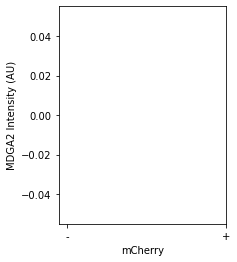

In [11]:

fig, ax = plt.subplots(1,1,figsize=(3,4))

targ_nR_list = []
targ_iR_list = []
for im_i in multi_image_results.keys():
    print( multi_image_results[im_i]['results'])
    targ_nR_list.append(   multi_image_results[im_i]['results']['targ_sig_nR'] )
    targ_iR_list.append(   multi_image_results[im_i]['results']['targ_sig_iR'] )

targ_iR_list = np.array(targ_iR_list)/np.array(targ_nR_list)
targ_nR_list = np.array(targ_nR_list)/np.array(targ_nR_list)


ax.bar(0,np.mean(targ_nR_list),zorder = 0,color='k',yerr=scipy.stats.sem(targ_nR_list))
ax.bar(1,np.mean(targ_iR_list),zorder = 0,color='r',yerr=scipy.stats.sem(targ_iR_list))
ax.scatter(np.zeros_like(targ_nR_list),targ_nR_list,zorder = 1,edgecolor='k',facecolor='w')
ax.scatter(np.ones_like(targ_iR_list),targ_iR_list,zorder = 1,edgecolor='r',facecolor='w')

ax.set_xticks([0,1])
ax.set_xticklabels(['-' , '+'])
ax.set_xlabel('mCherry')
ax.set_ylabel('MDGA2 Intensity (AU)')
plt.show()

In [12]:
multi_image_results[0].keys()

KeyError: ignored

In [ ]:
from google import colab

for k in multi_image_results.keys():
    multi_image_results[k]['cell_df']['Pos']=multi_image_results[k]['cell_df']['mean_mCherry']>1
    image_name = str(k).split('.')[0]
    multi_image_results[k]['cell_df'].to_csv(image_name + '_cell_stats.csv' )

for path, directories, files in os.walk('images'):
    for f in files:
        if '.csv' in f:
            print(f)
            colab.files.download( os.path.join('images',f))



In [ ]:
t =1

# from matplotlib.projections.polar import Axes
fov = multi_image_results[1]
zi = 9
sp_size =16
fig, axs = plt.subplots(2,2,figsize=(sp_size,sp_size))
axs =axs.flatten()
axs[0].imshow(fov['image_znorm'][2,zi,:,:],cmap='gray',vmax=3)
axs[0].contour(fov['exp_masks'][zi,:,:],cmap='prism')


axs[1].imshow(fov['masks'][zi,:,:]>0)
axs[1].contour(fov['exp_masks'][zi,:,:],cmap='prism')

cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["black","red"])
axs[2].imshow(fov['image_znorm'][1,zi,:,:],cmap=cmap, vmax=4)
axs[2].contour(fov['exp_masks'][zi,:,:],cmap='prism')


cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["black","green"])
axs[3].imshow(fov['image_znorm'][0,zi,:,:],cmap=cmap,vmin=-1, vmax=3)
axs[3].contour(fov['exp_masks'][zi,:,:],cmap='prism')


sp_size =4
n=4
cell_df = fov['cell_df']
fig, ax = plt.subplots(1,n,figsize=(n*sp_size,sp_size))
ax=ax.flatten()
_=ax[0].hist(cell_df['mean_mCherry'])
ax[0].set_xlabel('mCherry (z)')
ax[0].set_ylabel('Cells (#)')

_=ax[1].hist(cell_df['mean_target'])
ax[1].set_xlabel('Target (z)')
ax[1].set_ylabel('Cells (#)')

ax[2].scatter(cell_df['mean_mCherry'],cell_df['mean_target'])
ax[2].set_xlabel('mCherry (z)')
ax[2].set_ylabel('Target (z)')


vals=[cell_df['raw_mean_target'][cell_df['mean_mCherry']<t],
      cell_df['raw_mean_target'][cell_df['mean_mCherry']>t]]
means = [np.mean(v) for v in vals]
errors = [np.std(v)/np.sqrt(v.size) for v in vals]


ax[3].bar([0,1],means,yerr=errors)
ax[3].set_xticks([0,1])
ax[3].set_xticklabels(['Negative','Positive'])
ax[3].set_xlabel('mCherry')
ax[3].set_ylabel('Target Intensity (AU)')
# ax[3].set_xticks()
# ax[3].title.set_text('mean_NeuN')

plt.tight_layout()
plt.show()

In [ ]:
fig_sample, axs = plt.subplots(2,4,figsize=(24,12))
axs=axs.flatten()
axs[0].imshow(fov['image_znorm'][2,zi,:,:],cmap='gray',vmax=3)
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["black","red"])
axs[1].imshow(fov['image_znorm'][1,zi,:,:],cmap=cmap, vmax=4)
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["black","green"])
axs[2].imshow(fov['image_znorm'][0,zi,:,:],cmap=cmap,vmax=2)
w_sig = fov['image_znorm'][2,zi,:,:]
w_sig = w_sig+np.percentile(w_sig.flatten(),.1)
w_sig = w_sig/np.percentile(w_sig.flatten(),99.9)
w_chan = np.stack( [w_sig for i in range(3)] ,axis=-1)
r_sig = fov['image_znorm'][1,zi,:,:]
r_sig = r_sig+np.percentile(r_sig.flatten(),.0)
r_sig = r_sig/np.percentile(r_sig.flatten(),100)
r_chan = np.stack( [r_sig, np.zeros_like(r_sig), np.zeros_like(r_sig)],axis=-1)
g_sig = fov['image_znorm'][0,zi,:,:]
g_sig = g_sig-(np.percentile(g_sig.flatten(),0)*2)
g_sig = g_sig/(np.percentile(g_sig.flatten(),100)*1)
g_chan = np.stack( [ np.zeros_like(g_sig), g_sig, np.zeros_like(g_sig)],axis=-1)
gain = 2
merge = w_chan + r_chan + g_chan
axs[3].imshow(merge)


axs[0].text(10,790,'NeuN',color='w',fontsize=24)
axs[1].text(10,790,'mCherry',color=[1,0,0,1],fontsize=24)
axs[2].text(10,790,'MDGA2',color=[0,1,0,1],fontsize=24)
# axs[3].text(0,800,'NeuN',color='w')


y1,y2,x1,x2, = [150,350,0,200,]

my_rect = matplotlib.patches.Rectangle([y1,x1],  y2-y1, x2-x1,alpha=1, facecolor='none',edgecolor='c',linewidth=3)
axs[0].add_patch(my_rect)


# fig, axs = plt.subplots(1,4,figsize=(32,8))
# axs=axs.flatten()
axs[4].imshow(fov['image_znorm'][2,zi,x1:x2,y1:y2],cmap='gray',vmax=3)
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["black","red"])
axs[5].imshow(fov['image_znorm'][1,zi,x1:x2,y1:y2],cmap=cmap, vmax=4)
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["black","green"])
axs[6].imshow(fov['image_znorm'][0,zi,x1:x2,y1:y2],cmap=cmap,vmax=2)
axs[7].imshow(merge[x1:x2,y1:y2,:])

for a in axs:
    a.get_xaxis().set_visible(False)
    a.get_yaxis().set_visible(False)
plt.tight_layout(pad=1.1)


pxl_per_um = 800/160
sb_x = 780
sb_y = 10
big_scale_bar = matplotlib.patches.Rectangle([sb_x,sb_y],   -25*pxl_per_um , 10, alpha=1, facecolor='w',edgecolor='w',linewidth=0)
axs[0].add_patch(big_scale_bar)
sb_x = 195
sb_y = 4
small_scale_bar = matplotlib.patches.Rectangle([sb_x,sb_y],   -5*pxl_per_um , 3, alpha=1, facecolor='w',edgecolor='w',linewidth=0)
axs[4].add_patch(small_scale_bar)
fig_sample.savefig('sample_MDGA2.png')






In [ ]:




inset_xy =  [150,350,0,200]
plot_sample(fov,inset_xy)

In [ ]:
image_name= os.path.basename(fov['image_name']).split('.')[0]
potential_targets = ['MDGA2','Nell2','RNF182']
target_name = [t for t in potential_targets if t in image_name][0]
print(target_name)

In [ ]:
sp_size = 8

t = 1
for zi in range(16):
    fig, axs = plt.subplots(1,2,figsize=(sp_size*2,sp_size))
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["black","red"])
    axs[0].imshow(fov['image_znorm'][1,zi,:,:],cmap=cmap, vmax=4)
    axs[0].contour(fov['exp_masks'][zi,:,:],cmap='prism')
    pos_neg_mask = fov['exp_masks'].copy()
    pos_cells = cell_df.index[cell_df['mean_mCherry']>t]
    # pos_neg_mask[pos_neg_mask==0]=np.nan
    pos_neg_mask = pos_neg_mask*-1
    for c in tqdm( pos_cells.values) :
        pos_neg_mask[pos_neg_mask==-c]=1.
    pos_neg_mask = (pos_neg_mask>0)*1.
    pos_neg_mask[fov['exp_masks']==0]=-1
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["white","black","red"])
    axs[1].imshow(pos_neg_mask[zi,:,:],cmap=cmap)
    axs[1].contour(fov['exp_masks'][zi,:,:],cmap='prism')


In [ ]:
print(multi_image_results[0]['results'])

In [ ]:
import numpy as np
import h5py
from google import colab
sub_f = 'data'
zip_name = sub_f+'.zip'
try: os.makedirs(sub_f)
except: None
try: hf.close()
except: None
for f in multi_image_results:
    image_name_loc = f['image_name']
    h5_name = os.path.basename(image_name_loc).split('.')[0]
    hf = h5py.File( sub_f+'/'+h5_name+'.h5', 'w')
    for k,v in f.items():
        hf.create_dataset(k, data=v)
    hf.close()
!zip -r $zip_name $sub_f
colab.files.download(zip_name)
